# Weak/Integral SINDy Feature Overview

This notebook provides a simple overview of the weak form PDE functionality of PySINDy, following the examples in the PDE-FIND paper (Rudy, Samuel H., Steven L. Brunton, Joshua L. Proctor, and J. Nathan Kutz. "Data-driven discovery of partial differential equations." Science Advances 3, no. 4 (2017): e1602614) and Reinbold, P. A., Gurevich, D. R., & Grigoriev, R. O. (2020). Using noisy or incomplete data to discover models of spatiotemporal dynamics. Physical Review E, 101(1), 010203. Jupyter notebook written by Alan Kaptanoglu.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/dynamicslab/pysindy/v0.13.0?filepath=example%2Ffeature_overview.ipynb)

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import odeint
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error

import pysindy as ps

# Seed the random number generators for reproducibility
np.random.seed(100)

In [2]:
# Import some interpolation and integration functions
from scipy.interpolate import RectBivariateSpline
from scipy.integrate import trapezoid
from pysindy.differentiation import FiniteDifference
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import interp1d


# Convert u_dot into a weak form using the pre-defined ode_lib
def convert_u_dot_0D(u, t, ode_lib):
    K = ode_lib.K
    num_pts_per_domain = ode_lib.num_pts_per_domain
    u_dot_integral = np.zeros((K, u.shape[-1]))
    for j in range(u.shape[-1]):
        u_interp = interp1d(t, u[:, j], kind='cubic')
        for k in range(K):
            # Interpolate u onto the kth subdomain
            u_new = u_interp(ode_lib.tgrid_k[k, :])
            # Get the smooth weights on the kth subdomain
            w_diff = ode_lib._smooth_ppoly(
                        [],
                        ode_lib.tgrid_k[k, :], k, 0, 0, 1
                    )
            # Integrate over t points in the kth subdomain
            u_dot_integral[k, j] = (-1) * (
                trapezoid(
                    u_new * w_diff, 
                    x=ode_lib.tgrid_k[k, :], 
                    axis=0
                )
            )
    return u_dot_integral


# Convert u_dot into a weak form using the pre-defined pde_lib
def convert_u_dot_1D(u, t, pde_lib):
    K = pde_lib.K
    num_pts_per_domain = pde_lib.num_pts_per_domain
    x = pde_lib.spatial_grid
    u_dot_integral = np.zeros((K, u.shape[-1]))
    u_shaped = np.reshape(u, (len(x), len(t), u.shape[-1]))
    # Define interpolation object to interpolate u(x, time) onto the grid
    # spanned by X, t
    for j in range(u.shape[-1]):
        u_interp = RectBivariateSpline(x, t, u_shaped[:, :, j])
        for k in range(K):
            X = np.ravel(pde_lib.X[k, :, :])
            t = np.ravel(pde_lib.t[k, :, :])
            # Interpolate u onto the kth subdomain
            u_new = u_interp.ev(X, t)
            u_new = np.reshape(u_new, (num_pts_per_domain,
                                       num_pts_per_domain,
                                       1))
            # Get the smooth weights on the kth subdomain
            w_diff = pde_lib._smooth_ppoly(
                        np.reshape(pde_lib.xgrid_k[k, :], (num_pts_per_domain, 1)),
                        pde_lib.tgrid_k[k, :], k, 0, 0, 1
                    )
            # Integrate over x, t points in the kth subdomain
            u_dot_integral[k, j] = (-1) * (
                trapezoid(
                    trapezoid(
                        u_new * w_diff, 
                        x=pde_lib.xgrid_k[k, :], 
                        axis=0
                    ),
                    x=pde_lib.tgrid_k[k, :], 
                    axis=0
                )
            )
    return u_dot_integral


# Convert u_dot into a weak form using the pre-defined pde_lib
def convert_u_dot_2D(u, pde_lib):
    K = pde_lib.K  
    num_pts_per_domain = pde_lib.num_pts_per_domain
    u_dot_integral = np.zeros((K, 2))
    u_shaped = np.reshape(u, (n, n, len(time), 2))
    for j in range(u.shape[-1]):
        # Define interpolation object to interpolate u(x, y, time) onto the grid
        # spanned by X, Y, t
        u_interp = RegularGridInterpolator((x, y, time), u_shaped[:, :, :, j])
        for k in range(K):
            X = np.ravel(pde_lib.X[k, :])
            Y = np.ravel(pde_lib.Y[k, :])
            t = np.ravel(pde_lib.t[k, :])
            XYt = np.array((X, Y, t)).T
            # Interpolate u onto the kth subdomain
            u_new = u_interp(XYt)
            u_new = np.reshape(u_new, (num_pts_per_domain,
                                       num_pts_per_domain,
                                       num_pts_per_domain,
                                       1))
            # Get the smooth weights on the kth subdomain
            w_diff = pde_lib._smooth_ppoly(
                        np.transpose((pde_lib.xgrid_k[k, :], pde_lib.ygrid_k[k, :])),
                        pde_lib.tgrid_k[k, :], k, 0, 0, 1
                    )
            # Integrate over x, y, t points in the kth subdomain
            u_dot_integral[k, j] = (-1) * (
                trapezoid(
                    trapezoid(
                        trapezoid(
                            u_new * w_diff, 
                            x=pde_lib.xgrid_k[k, :], 
                            axis=0
                        ),
                        x=pde_lib.ygrid_k[k, :],
                        axis=0
                    ),
                    x=pde_lib.tgrid_k[k, :], 
                    axis=0
                )
            )
    return u_dot_integral

# Test weak form ODE functionality on Lorenz equation

In [20]:
def lorenz(z, t):
    return [
        10 * (z[1] - z[0]),
        z[0] * (28 - z[2]) - z[1],
        z[0] * z[1] - (8 / 3) * z[2]
    ]

# Generate measurement data
dt = .002
t_train = np.arange(0, 10, dt)
u0_train = [-8, 8, 27]
u_train = odeint(lorenz, u0_train, t_train)

# Instantiate and fit the SINDy model with u_dot
u_dot = ps.FiniteDifference()._differentiate(u_train, t=dt)
model = ps.SINDy()
model.fit(u_train, x_dot=u_dot, t=dt)
model.print()

# Define weak form ODE library via weak_form=True, 
# defaults to derivative_order = 0 if not specified,
# and if spatial_grid is not specified, defaults to None,
# which allows weak form ODEs.
library_functions = [lambda x: x, lambda x: x * x, lambda x, y: x * y]
library_function_names = [lambda x: x, lambda x: x + x, lambda x, y: x + y]
ode_lib = ps.PDELibrary(library_functions=library_functions, 
                        function_names=library_function_names, 
                        temporal_grid=t_train, include_bias=True,
                        is_uniform=True, weak_form=True, 
                        num_pts_per_domain=100, K=100)

u_dot_train_integral = convert_u_dot_0D(u_train, t_train, ode_lib)

# Instantiate and fit the SINDy model with the integral of u_dot
optimizer = ps.SR3(threshold=0.05, thresholder='l1', 
                   max_iter=1000, normalize_columns=True,
                   tol=1e-10)
model = ps.SINDy(feature_library=ode_lib, optimizer=optimizer)
model.fit(u_train, x_dot=u_dot_train_integral)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1
x0' = -10.000 x0 + 10.000 x1
x1' = 28.000 x0 + -1.000 x1 + -1.000 x0x2
x2' = -2.667 x2 + 1.000 x0x1


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 1000 iterations.
  ConvergenceWarning,


### Performance should improve as number of sub-domain integrations points (num_pts_per_domain) and number of sub-domains (K) increase. Let's use some noisy Lorenz data and investigate.

In [41]:
# Generate measurement data
dt = .002
t_train = np.arange(0, 10, dt)
u0_train = [-8, 8, 27]
u_train = odeint(lorenz, u0_train, t_train)
rmse = mean_squared_error(u_train, np.zeros(u_train.shape), squared=False)
u_train = u_train + np.random.normal(0, rmse / 10.0, u_train.shape)

# Instantiate and fit the SINDy model with u_dot
u_dot = ps.FiniteDifference()._differentiate(u_train, t=dt)
optimizer = ps.SR3(threshold=0.05, thresholder='l0', 
                   max_iter=1000, normalize_columns=True,
                   tol=1e-10)
model = ps.SINDy(optimizer=optimizer)
model.fit(u_train, x_dot=u_dot, t=dt)
model.print()
err_not_weak = np.sqrt(np.sum((u_dot - optimizer.Theta @ optimizer.coef_.T) ** 2)
                            ) / np.sqrt(np.sum(u_dot ** 2))

# Same library terms as before
library_functions = [lambda x: x, lambda x: x * x, lambda x, y: x * y]
library_function_names = [lambda x: x, lambda x: x + x, lambda x, y: x + y]

n = 20
errs = np.zeros((n, n))
pts_scan = np.linspace(20, 300, n, dtype=int)
K_scan = np.linspace(20, 300, n, dtype=int)
for i, K in enumerate(K_scan):
    print(i)  # Track loop progress
    for j, pts in enumerate(pts_scan):
        ode_lib = ps.PDELibrary(library_functions=library_functions, 
                                function_names=library_function_names, 
                                temporal_grid=t_train, include_bias=True,
                                is_uniform=True, weak_form=True, 
                                num_pts_per_domain=pts, K=K)

        u_dot_train_integral = convert_u_dot_0D(u_train, t_train, ode_lib)

        # Instantiate and fit the SINDy model with the integral of u_dot
        model = ps.SINDy(feature_library=ode_lib, optimizer=optimizer)
        model.fit(u_train, x_dot=u_dot_train_integral, quiet=True)
        # model.print()
        errs[i, j] = np.sqrt(np.sum((u_dot_train_integral - optimizer.Theta @ optimizer.coef_.T) ** 2)
                            ) / np.sqrt(np.sum(u_dot_train_integral ** 2))

x0' = -31.899 1 + -3.701 x0 + 5.352 x1 + 3.937 x2 + 0.424 x0^2 + -0.283 x0 x1 + -0.148 x0 x2 + -0.001 x1^2 + 0.103 x1 x2 + -0.114 x2^2
x1' = 29.361 1 + 13.951 x0 + 6.795 x1 + -2.957 x2 + -0.425 x0^2 + 0.558 x0 x1 + -0.618 x0 x2 + -0.209 x1^2 + -0.199 x1 x2 + 0.085 x2^2
x2' = 30.286 1 + 2.268 x0 + 0.078 x1 + -6.903 x2 + -0.607 x0^2 + 1.254 x0 x1 + -0.025 x0 x2 + 0.067 x1^2 + -0.043 x1 x2 + 0.137 x2^2
0


/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_library.py:368: RuntimeWarning: divide by zero encountered in true_divide
  / self.Ht ** d_t
/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_library.py:368: RuntimeWarning: divide by zero encountered in true_divide
  / self.Ht ** d_t
/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_library.py:368: RuntimeWarning: divide by zero encountered in true_divide
  / self.Ht ** d_t
/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_library.py:368: RuntimeWarning: divide by zero encountered in true_divide
  / self.Ht ** d_t
/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_library.py:368: RuntimeWarning: divide by zero encountered in true_divide
  / self.Ht ** d_t
/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_library.py:368: RuntimeWarning: divide by zero encountered in true_divide
  / self.Ht ** d_t
/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_l

1


/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_library.py:368: RuntimeWarning: divide by zero encountered in true_divide
  / self.Ht ** d_t
/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_library.py:368: RuntimeWarning: divide by zero encountered in true_divide
  / self.Ht ** d_t
/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_library.py:368: RuntimeWarning: divide by zero encountered in true_divide
  / self.Ht ** d_t
/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_library.py:368: RuntimeWarning: divide by zero encountered in true_divide
  / self.Ht ** d_t
/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_library.py:368: RuntimeWarning: divide by zero encountered in true_divide
  / self.Ht ** d_t
/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_library.py:368: RuntimeWarning: divide by zero encountered in true_divide
  / self.Ht ** d_t
/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_l

2


/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_library.py:368: RuntimeWarning: divide by zero encountered in true_divide
  / self.Ht ** d_t
/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_library.py:368: RuntimeWarning: divide by zero encountered in true_divide
  / self.Ht ** d_t
/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_library.py:368: RuntimeWarning: divide by zero encountered in true_divide
  / self.Ht ** d_t
/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_library.py:368: RuntimeWarning: divide by zero encountered in true_divide
  / self.Ht ** d_t
/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_library.py:368: RuntimeWarning: divide by zero encountered in true_divide
  / self.Ht ** d_t
/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_library.py:368: RuntimeWarning: divide by zero encountered in true_divide
  / self.Ht ** d_t
/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_l

3


/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_library.py:368: RuntimeWarning: divide by zero encountered in true_divide
  / self.Ht ** d_t
/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_library.py:368: RuntimeWarning: divide by zero encountered in true_divide
  / self.Ht ** d_t
/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_library.py:368: RuntimeWarning: divide by zero encountered in true_divide
  / self.Ht ** d_t
/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_library.py:368: RuntimeWarning: divide by zero encountered in true_divide
  / self.Ht ** d_t
/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_library.py:368: RuntimeWarning: divide by zero encountered in true_divide
  / self.Ht ** d_t
/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_library.py:368: RuntimeWarning: divide by zero encountered in true_divide
  / self.Ht ** d_t
/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_l

4


/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_library.py:368: RuntimeWarning: divide by zero encountered in true_divide
  / self.Ht ** d_t
/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_library.py:368: RuntimeWarning: divide by zero encountered in true_divide
  / self.Ht ** d_t
/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_library.py:368: RuntimeWarning: divide by zero encountered in true_divide
  / self.Ht ** d_t
/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_library.py:368: RuntimeWarning: divide by zero encountered in true_divide
  / self.Ht ** d_t
/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_library.py:368: RuntimeWarning: divide by zero encountered in true_divide
  / self.Ht ** d_t
/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_library.py:368: RuntimeWarning: divide by zero encountered in true_divide
  / self.Ht ** d_t
/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_l

5


/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_library.py:368: RuntimeWarning: divide by zero encountered in true_divide
  / self.Ht ** d_t
/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_library.py:368: RuntimeWarning: divide by zero encountered in true_divide
  / self.Ht ** d_t
/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_library.py:368: RuntimeWarning: divide by zero encountered in true_divide
  / self.Ht ** d_t
/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_library.py:368: RuntimeWarning: divide by zero encountered in true_divide
  / self.Ht ** d_t
/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_library.py:368: RuntimeWarning: divide by zero encountered in true_divide
  / self.Ht ** d_t
/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_library.py:368: RuntimeWarning: divide by zero encountered in true_divide
  / self.Ht ** d_t
/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_l

6


/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_library.py:368: RuntimeWarning: divide by zero encountered in true_divide
  / self.Ht ** d_t
/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_library.py:368: RuntimeWarning: divide by zero encountered in true_divide
  / self.Ht ** d_t
/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_library.py:368: RuntimeWarning: divide by zero encountered in true_divide
  / self.Ht ** d_t
/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_library.py:368: RuntimeWarning: divide by zero encountered in true_divide
  / self.Ht ** d_t
/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_library.py:368: RuntimeWarning: divide by zero encountered in true_divide
  / self.Ht ** d_t
/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_library.py:368: RuntimeWarning: divide by zero encountered in true_divide
  / self.Ht ** d_t
/media/akaptano/HITSI-Work/pysindy/pysindy/feature_library/pde_l

KeyboardInterrupt: 

In [40]:
errs[0, :]

array([3.01013933e-12, 4.59309167e-13, 4.79103313e-13, 7.12673585e-14,
       1.99807397e-13, 7.16837434e-14, 3.83323594e-13, 5.49437950e-14,
       4.07850042e-14, 5.60355921e-13, 4.11598223e-13, 6.05388468e-14,
       3.70229659e-13, 8.00473583e-14, 3.20630845e-12, 1.21273011e-13,
       1.00145768e-13, 1.14492428e-13, 5.86828915e-13, 2.54409806e-13])

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


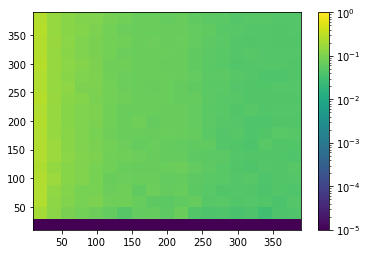

In [37]:
from matplotlib.colors import LogNorm
plt.pcolormesh(K_scan, pts_scan, errs, norm=LogNorm(vmin=1e-5, vmax=1))
plt.colorbar()

# Test weak form PDE functionality on Burgers' equation with 20% noise
Burgers' equation is
$u_t = -uu_x + 0.1 u_{xx}$. We will repeat all the same steps

In [ ]:
# Load data from .mat file
data = loadmat('data/burgers.mat')
time = np.ravel(data['t'])
x = np.ravel(data['x'])
u = np.real(data['usol'])
dt = time[1] - time[0]
dx = x[1] - x[0]
rmse = mean_squared_error(u, np.zeros(u.shape), squared=False)
u = u + np.random.normal(0, rmse / 5.0, u.shape)  # add 20% noise

# Plot u and u_dot
plt.figure()
plt.imshow(u, aspect='auto')
u_shaped = np.reshape(u, (len(x), len(time), 1))
u_dot = np.zeros((len(x), len(time), 1))

# See how much SmoothedFiniteDifference improves the derivatives!
plt.figure()
for i in range(len(x)):
    u_dot[i, :, :] = ps.FiniteDifference()._differentiate(u_shaped[i, :, :], t=dt)
plt.imshow(u_dot[:, :, 0], aspect='auto')
plt.figure()
for i in range(len(x)):
    u_dot[i, :, :] = ps.SmoothedFiniteDifference()._differentiate(u_shaped[i, :, :], t=dt)
plt.imshow(u_dot[:, :, 0], aspect='auto')

In [ ]:
# Split into training and testing data
train = range(0, len(time) // 2, 1)
test = [i for i in np.arange(len(time)) if i not in train]
u_train = u[:, train]
u_test = u[:, test]
t_train = time[train]
t_test = time[test]

# Flatten into 2D shape for SINDy model optimization
u_flattened = np.reshape(u, (len(x) * len(time), 1))
u_train_flattened = np.reshape(u_train, (len(x) * len(t_train), 1))
u_test_flattened = np.reshape(u_test, (len(x) * len(t_test), 1))

# Define weak form PDE library via weak_form=True
library_functions = [lambda x: x]  # , lambda x: x * x]
library_function_names = [lambda x: x]  # , lambda x: x + x]
pde_lib = ps.PDELibrary(library_functions=library_functions, 
                        function_names=library_function_names, 
                        derivative_order=2, spatial_grid=x,
                        temporal_grid=time, include_bias=False,
                        is_uniform=True, weak_form=True, K=100,
                        num_pts_per_domain=100)

u_dot_train_integral = convert_ut(u_train, t_train, pde_lib)
u_dot_test_integral = convert_ut(u_test, t_test, pde_lib)
u_dot_integral = convert_ut(u, time, pde_lib)

In [ ]:
# Fit a model
optimizer = ps.STLSQ(threshold=0.01, alpha=0.0, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_flattened, x_dot=u_dot_integral)
model.print()

# Test PDE functionality on the Kuramoto-Sivashinsky equation
The Kuramoto-Sivashinsky equation is
$u_t = -uu_x - u_{xx} - u_{xxxx}$.

In [ ]:
# Load and plot the data
data = loadmat('data/kuramoto_sivishinky.mat')
time = np.ravel(data['tt'])
x = np.ravel(data['x'])
u = data['uu']
u_flattened = np.reshape(u, (len(x) * len(time), 1))
dt = time[1] - time[0]
dx = x[1] - x[0]
plt.figure()
plt.imshow(u, aspect='auto')

# Convert u_dot to weak form and then solve problem with all the optimizers

In [ ]:
# Split into training and testing data
train = range(0, len(time) // 2, 1)
test = [i for i in np.arange(len(time)) if i not in train]
u_train = u[:, train]
u_test = u[:, test]
t_train = time[train]
t_test = time[test]

# Flatten into 2D shape for SINDy model optimization
u_train_flattened = np.reshape(u_train, (len(x) * len(t_train), 1))
u_test_flattened = np.reshape(u_test, (len(x) * len(t_test), 1))

# Define weak form PDE library via weak_form=True
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(library_functions=library_functions, 
                        function_names=library_function_names, 
                        derivative_order=4, spatial_grid=x, Hx=24.5, Ht=20,
                        temporal_grid=time, include_bias=True,
                        is_uniform=True, weak_form=True, num_pts_per_domain=50)
u_dot_train_integral = convert_ut(u_train, t_train, pde_lib)
u_dot_test_integral = convert_ut(u_test, t_test, pde_lib)
u_dot_integral = convert_ut(u, time, pde_lib)

In [ ]:
# Run optimizers -- skipping SSR for now
optimizer = ps.STLSQ(threshold=0.001, alpha=0.05, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_flattened, x_dot=u_dot_integral)
model.print()

optimizer = ps.SR3(threshold=0.1, max_iter=10000, tol=1e-15, 
                   thresholder='l0', normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_flattened, x_dot=u_dot_integral)
model.print()

optimizer = ps.SR3(threshold=0.01, max_iter=10000, tol=1e-15, 
                   thresholder='l1', normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_flattened, x_dot=u_dot_integral)
model.print()

# optimizer = ps.SSR(normalize_columns=True, kappa=1e-8)
# model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
# model.fit(u_flattened, x_dot=ut_integral)
# model.print()

# optimizer = ps.SSR(criteria='model_residual', normalize_columns=True, kappa=1e-20)
# model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
# model.fit(u_flattened, x_dot=ut_integral)
# model.print()

optimizer = ps.FROLS(normalize_columns=True, kappa=1e-7)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_flattened, x_dot=u_dot_integral)
model.print()

In [ ]:
# Get average SR3 performance as function of the noise level,
# cross-validated over 10 runs. This runs for a few minutes on my desktop.
cross_val_runs = 10
noise_levels = [0, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1]
delta_c1 = np.zeros((cross_val_runs, len(noise_levels)))
delta_c2 = np.zeros((cross_val_runs, len(noise_levels)))
delta_c3 = np.zeros((cross_val_runs, len(noise_levels)))
for i in range(cross_val_runs):
    print(i)
    for j, noise in enumerate(noise_levels):
        pde_lib = ps.PDELibrary(library_functions=library_functions, 
                            function_names=library_function_names, 
                            derivative_order=4, spatial_grid=x, Hx=24.5, Ht=20,
                            temporal_grid=time, include_bias=False, 
                            is_uniform=True, weak_form=True, num_pts_per_domain=50)
        u_noisy = u + np.random.normal(0, noise, u.shape)
        u_noisy_flattened = np.ravel(u)
        ut_integral = convert_ut(u_noisy, time, pde_lib)
        optimizer = ps.SR3(threshold=0.01, max_iter=200, tol=1e-10, 
                           thresholder='l1', normalize_columns=True)
        model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
        model.fit(u_noisy_flattened, x_dot=u_dot_integral)
        model.print()
        c1 = abs(optimizer.coef_[0, 6])
        c2 = abs(optimizer.coef_[0, 3])
        c3 = abs(optimizer.coef_[0, 5])
        delta_c1[i, j] = abs(abs(c1 - 1.0) / c1)
        delta_c2[i, j] = abs(abs(c2 - 1.0) / c2)
        delta_c3[i, j] = abs(abs(c3 - 1.0) / c3)

In [ ]:
delta_c1_mean = np.nanmean(delta_c1, axis=0)
delta_c2_mean = np.nanmean(delta_c2, axis=0)
delta_c3_mean = np.nanmean(delta_c3, axis=0)

delta_c1_std = np.nanstd(delta_c1, axis=0)
delta_c2_std = np.nanstd(delta_c2, axis=0)
delta_c3_std = np.nanstd(delta_c3, axis=0)

# Plot average and standard deviations of the coefficient errors
plt.figure()
plt.errorbar(noise_levels, y=delta_c1_mean, yerr=delta_c1_std, color='r', fmt='o', label=r'$\Delta\xi_{uu_x}$')
plt.errorbar(noise_levels, y=delta_c2_mean, yerr=delta_c2_std, color='b', fmt='o', label=r'$\Delta\xi_{u_{xx}}$')
plt.errorbar(noise_levels, y=delta_c3_mean, yerr=delta_c3_std, color='k', fmt='o', label=r'$\Delta\xi_{u_{xxxx}}$')
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=14, loc='upper left', ncol=3)  #, framealpha=1.0, bbox_to_anchor=(1.05, 1))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
ax = plt.gca()
ax.set_ylim(1e-5, 1)
plt.savefig('SR3_weakformPDE_KS.pdf')

# Test weak form PDE functionality on Reaction-Diffusion system
This 2D system is significantly more complicated. The reaction-diffusion system exhibits spiral waves on a periodic domain,and the PDEs are:
$$u_t = 0.1\nabla^2 u + (1-A^2)u +\beta A^2v$$
$$v_t = 0.1\nabla^2 v - \beta A^2 u + (1-A^2)v$$
$$A^2 = u^2 + v^2.$$
The main change will be a significantly larger library... cubic terms in (u, v) and all their first and second order derivatives. We will also need to generate the data because saving a high-resolution form of the data makes a fairly large file.

### Note that Rudy PDE-FIND paper and Messenger Weak SINDy paper use 256 spatial points in each spatial direction, but Reinbold PRE paper uses 512 points in each direction. We will try and get away with 128 points in each direction and still show robustness to ~ 10% noise levels

In [ ]:
from scipy.integrate import solve_ivp
from numpy.fft import fft2, ifft2

# Define the reaction-diffusion PDE in the Fourier (kx, ky) space
def reaction_diffusion(t, uvt, K22, d1, d2, beta, n, N):
    ut = np.reshape(uvt[:N], (n, n))
    vt = np.reshape(uvt[N:2 * N], (n, n))
    u = np.real(ifft2(ut))
    v = np.real(ifft2(vt))
    u3 = u ** 3
    v3 = v ** 3
    u2v = (u ** 2) * v
    uv2 = u * (v ** 2)
    utrhs = np.reshape((fft2(u - u3 - uv2 + beta * u2v + beta * v3)), (N, 1))
    vtrhs = np.reshape((fft2(v - u2v - v3 - beta * u3 - beta * uv2)), (N, 1))
    uvt_reshaped = np.reshape(uvt, (len(uvt), 1))
    uvt_updated = np.squeeze(np.vstack((-d1 * K22 * uvt_reshaped[:N] + utrhs, 
                                        -d2 * K22 * uvt_reshaped[N:] + vtrhs)))
    return uvt_updated


# Generate the data
t = np.linspace(0, 10, int(10 / 0.05))
d1 = 0.1
d2 = 0.1
beta = 1.0
L = 20  # Domain size in X and Y directions
# use n = 32 for speed but then the high-order derivatives are terrible
n = 128  # Number of spatial points in each direction
N = n * n
x_uniform = np.linspace(- L / 2, L / 2, n + 1) 
x = x_uniform[:n]
y = x_uniform[:n]
n2 = int(n / 2)
# Define Fourier wavevectors (kx, ky)
kx = (2 * np.pi / L) * np.hstack((np.linspace(0, n2 - 1, n2), np.linspace(- n2, - 1, n2)))
ky = kx
# Get 2D meshes in (x, y) and (kx, ky)
X, Y = np.meshgrid(x, y)
KX, KY = np.meshgrid(kx, ky)
K2 = KX ** 2 + KY ** 2
K22 = np.reshape(K2, (N, 1))

m = 1  # number of spirals

# define our solution vectors 
u = np.zeros((len(x), len(y), len(t)))
v = np.zeros((len(x), len(y), len(t)))

# Initial conditions
u[:, :, 0] = np.tanh(np.sqrt(X ** 2 + Y ** 2)) * np.cos(m * np.angle(X + 1j * Y) - (np.sqrt(X ** 2 + Y ** 2)))
v[:, :, 0] = np.tanh(np.sqrt(X ** 2 + Y ** 2)) * np.sin(m * np.angle(X + 1j * Y) - (np.sqrt(X ** 2 + Y ** 2)))

# uvt is the solution vector in Fourier space, so below
# we are initializing the 2D FFT of the initial condition, uvt0
uvt0 = np.squeeze(np.hstack((np.reshape(fft2(u[:, :, 0]), (1, N)), np.reshape(fft2(v[:, :, 0]), (1, N)))))

# Solve the PDE in the Fourier space, where it reduces to system of ODEs
uvsol = solve_ivp(reaction_diffusion, (t[0], t[-1]), y0=uvt0, t_eval=t, args=(K22, d1, d2, beta, n, N))
uvsol = uvsol.y

# Reshape things and ifft back into (x, y, t) space from (kx, ky, t) space
for j in range(len(t)):
    ut = np.reshape(uvsol[:N, j], (n, n))
    vt = np.reshape(uvsol[N:, j], (n, n))
    u[:, :, j] = np.real(ifft2(ut))
    v[:, :, j] = np.real(ifft2(vt))

# Plot to check if spiral is nicely reproduced
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolor(X, Y, u[:, :, 10])
plt.subplot(1, 2, 2)
plt.pcolor(X, Y, v[:, :, 10])

dt = t[1] - t[0]
dx = x[1] - x[0]
dy = y[1] - y[0]

u_sol = u
v_sol = v

In [ ]:
time = t
u = np.zeros((n, n, len(time), 2))
u[:, :, :, 0] = u_sol
u[:, :, :, 1] = v_sol
u_flattened = np.reshape(u, (N * len(time), 2))

# Odd polynomial terms in (u, v), up to second order derivatives in (u, v)
library_functions = [lambda x: x, lambda x: x * x * x, lambda x, y: x * y * y, lambda x, y: x * x * y]
library_function_names = [lambda x: x, lambda x: x + x + x, lambda x, y: x + y + y, lambda x, y: x + x + y]

# Need to define the 2D spatial grid before calling the library
X, Y = np.meshgrid(x, y)
spatial_grid = np.asarray([X, Y]).T
pde_lib = ps.PDELibrary(library_functions=library_functions, 
                        function_names=library_function_names, 
                        derivative_order=2, spatial_grid=spatial_grid,
                        temporal_grid=time, include_bias=False,
                        is_uniform=True, weak_form=True, num_pts_per_domain=30)
u_dot_integral = convert_ut_2D(u, time, pde_lib)

In [ ]:
# Fit the 2D reaction-diffusion equation, weak form style!
optimizer = ps.STLSQ(threshold=0.05, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_flattened, x_dot=u_dot_integral)
model.print()

In [ ]:
# Fit the 2D reaction-diffusion equation, weak form style!
rms = mean_squared_error(u_flattened, np.zeros(u_flattened.shape))
u_flattened_noisy = u_flattened + np.random.normal(0, rms / 50.0, u_flattened.shape)
u_dot_integral_noisy = convert_ut_2D(u_flattened_noisy, pde_lib)
optimizer = ps.STLSQ(threshold=0.05, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_flattened_noisy, x_dot=u_dot_integral_noisy)
model.print()